## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor')  # Cache generated in "Anchors" notebook
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_agi')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_turing')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_parity')
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 24.5,
 5: 26.0,
 10: 26.8,
 20: 27.7,
 30: 28.6,
 40: 29.8,
 50: 31.4,
 60: 33.4,
 70: 35.6,
 80: 38.1,
 90: 41.7,
 95: 44.7,
 99: 50.6}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.5,
 80: 8.7,
 90: 9.0,
 95: 9.3,
 99: 9.8}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

# del delay['real_world_feedback']
# del delay['robotics']
delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=1.7, sd=0.37)
   - <Distribution> lognorm(mean=2.25, sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=1.15, sd=0.7)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=0.8, sd=0.49)
   - <Distribution> lognorm(mean=1.96, sd=0.21)},
 'real_world_feedback': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=0.8, sd=0.49)
   - <Distribution> lognorm(mean=1.96, sd=0.21)
   - <Distribution> lognorm(mean=2.85, sd=0.33)},
 'policy_pause': {'prob': <function __main__.derive_nonscaling_d

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': 5,
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(2, 3),         # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 24),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1.5, 4.5, lclip=1),
             '2025_spend_doubling_time': sq.norm(0.93, 1.05, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 39.3 log FLOP (~2 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~754 million). This doubles every 1.1 years to a max of 0.064248% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 39.3 log FLOP (2 million decillion) - log $ 21.0 to buy TAI (1 sextillion) vs. willingness to pay log $ 8.9 (717 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 39.0 log FLOP (998 thousand decillion) - log $ 20.6 to buy TAI (394 quintillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.9 max log FLOP (7

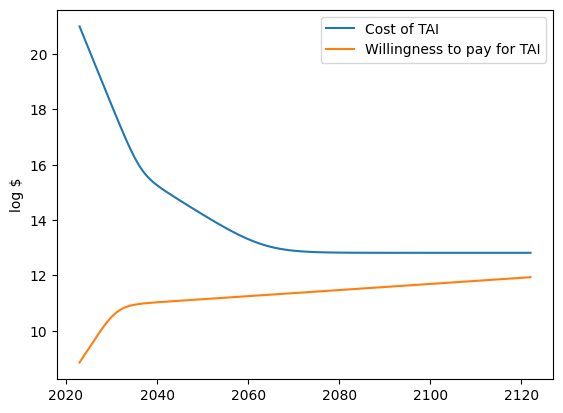

-
-
## SAMPLE RUN 2 ##
It takes 38.8 log FLOP (~631 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 2.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.0 max log FLOP (98 septillion) available - TAI takes 38.8 log FLOP (631 thousand decillion) - log $ 20.5 to buy TAI (317 quintillion) vs. willingness to pay log $ 7.7 (49 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (179 septillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 20.1 to buy TAI (120 quintillion) vs. willingness to pay log $ 7.8 (68 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max lo

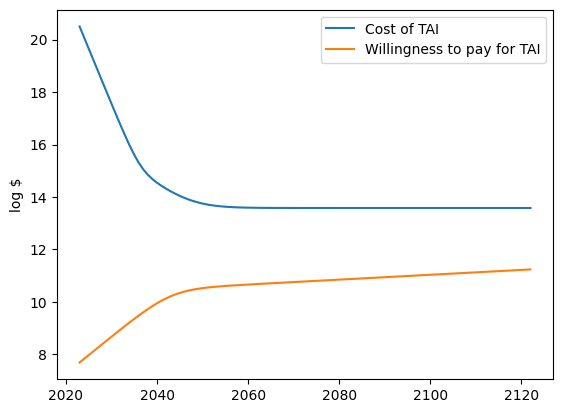

-
-
## SAMPLE RUN 3 ##
It takes 30.7 log FLOP (~5 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~244 million). This doubles every 2.2 years to a max of 0.03743% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.7 max log FLOP (474 septillion) available - TAI takes 30.7 log FLOP (5 nonillion) - log $ 12.4 to buy TAI (3 trillion) vs. willingness to pay log $ 8.4 (237 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (815 septillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.2 to buy TAI (2 trillion) vs. willingness to pay log $ 8.5 (323 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max log FLOP (1 octillion) available - TA

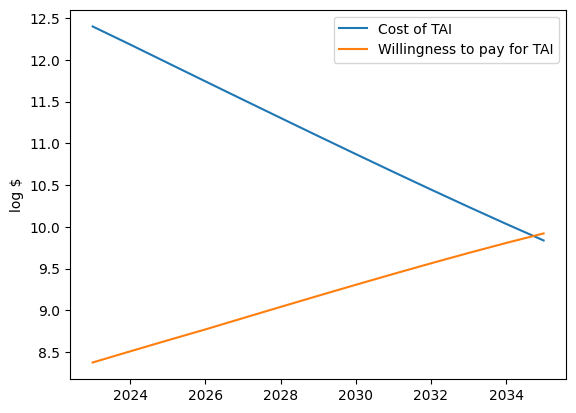

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 159.67it/s]


Shuffling data...
Waiting for other cores...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1225.54it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2030',
 '10%: 2031',
 '15%: 2033',
 '20%: 2034',
 '25%: 2035',
 '35%: 2037',
 '50%: 2042',
 '60%: 2047',
 '75%: 2081',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 7 years from now',
 '10%: 8 years from now',
 '15%: 10 years from now',
 '20%: 11 years from now',
 '25%: 12 years from now',
 '35%: 14 years from now',
 '50%: 19 years from now',
 '60%: 24 years from now',
 '75%: 58 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.6%
2028-2029: 4.1%
2030-2034: 19.3%
2035-2039: 19.5%
2040-2049: 19.1%
2050-2059: 7.1%
2060-2069: 3.7%
2070-2079: 1.2%
2080-2089: 0.8%
2090-2099: 0.5%
2100-2109: 0.5%
2110-2119: 0.4%
>2120: 22.8%
-
-
##

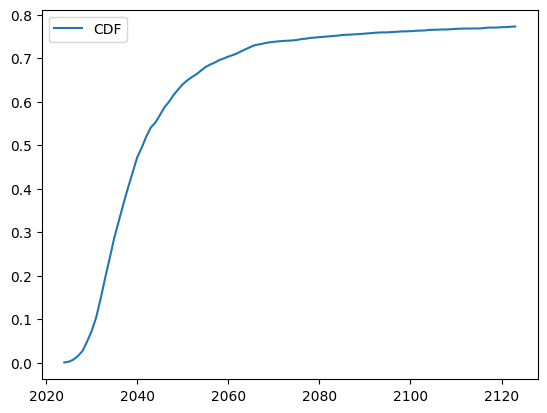

<string>:162: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

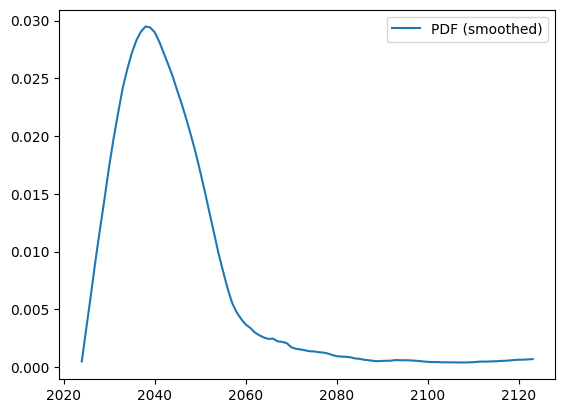

-
-
## TAI FLOP SIZE ##
{1: 24.5,
 5: 25.8,
 10: 26.5,
 20: 27.6,
 30: 28.6,
 40: 29.7,
 50: 31.7,
 60: 33.9,
 70: 36.2,
 80: 38.5,
 90: 42.0,
 95: 45.2,
 99: 50.8}


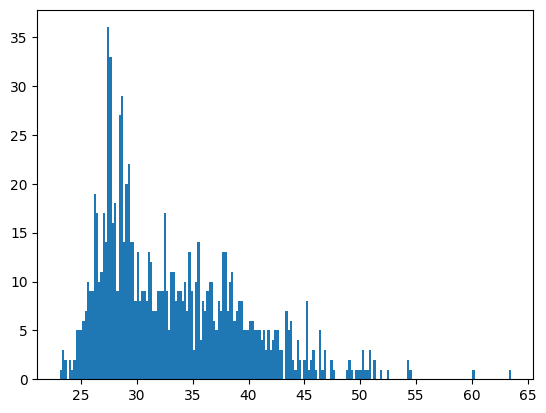

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION: 5 ##
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.2,
 5: 3.0,
 10: 2.9,
 20: 2.8,
 30: 2.7,
 40: 2.6,
 50: 2.5,
 60: 2.4,
 70: 2.3,
 80: 2.2,
 90: 2.1,
 95: 2.0,
 99: 1.8}


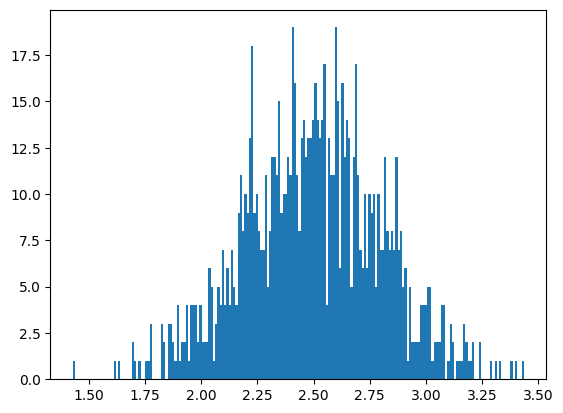

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.3,
 5: 21.0,
 10: 21.3,
 20: 21.7,
 30: 22.0,
 40: 22.3,
 50: 22.5,
 60: 22.7,
 70: 22.9,
 80: 23.2,
 90: 23.6,
 95: 23.9,
 99: 24.6}


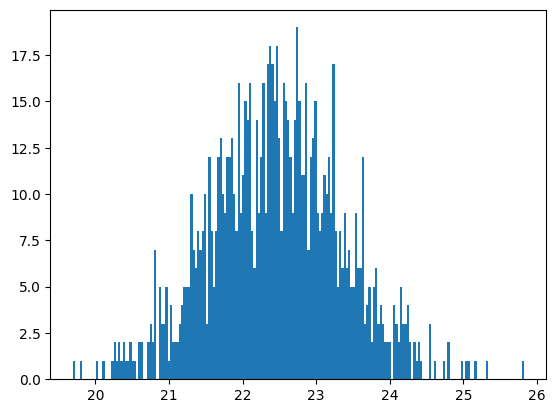

-
-
## INITIAL PAY ##
{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.5,
 80: 8.7,
 90: 9.0,
 95: 9.2,
 99: 9.8}


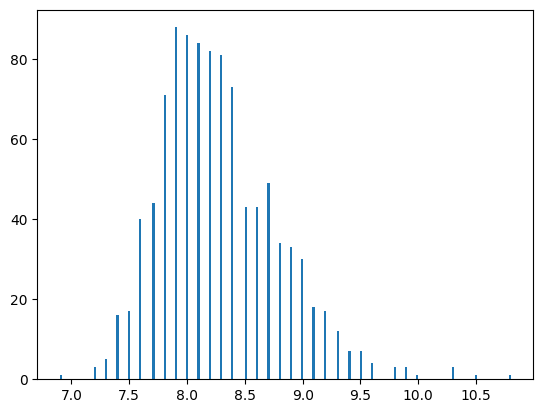

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.04,
 99: 1.04}


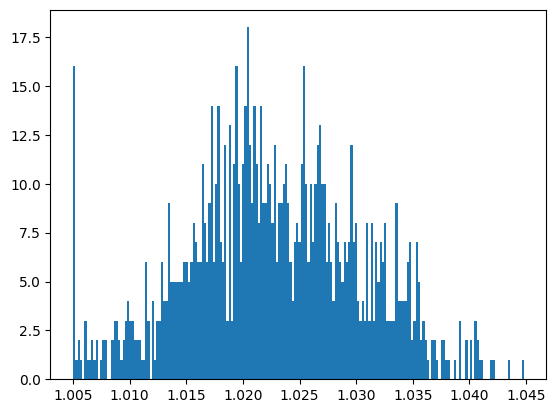

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.0004,
 60: 0.00051,
 70: 0.00072,
 80: 0.00113,
 90: 0.00236,
 95: 0.00365,
 99: 0.00874}


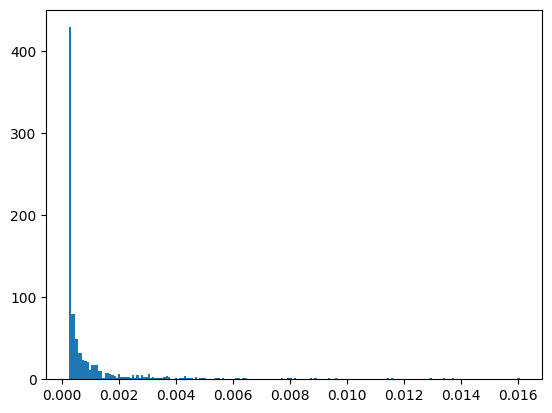

-
-
## SPEND DOUBLING TIME ##
{1: 5.3,
 5: 4.5,
 10: 4.1,
 20: 3.8,
 30: 3.5,
 40: 3.2,
 50: 3.0,
 60: 2.8,
 70: 2.6,
 80: 2.3,
 90: 1.8,
 95: 1.5,
 99: 1.0}


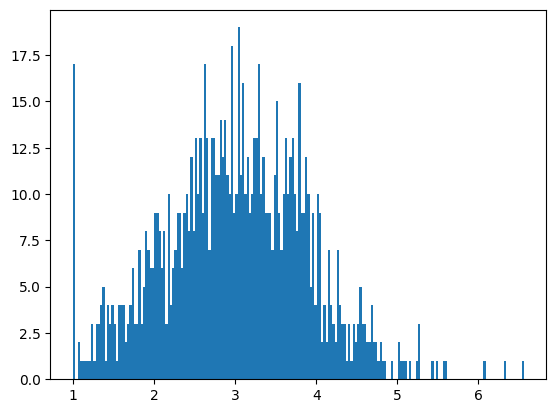

-
-
-
-
## GDP Over Time ##


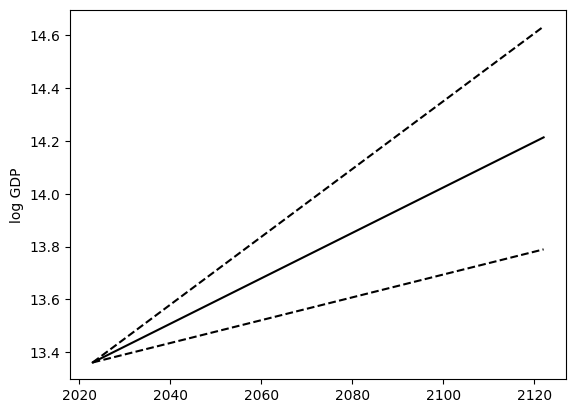

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

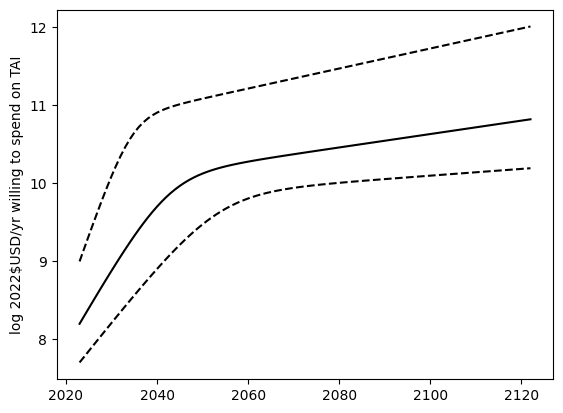

Year: 2023 - willingness log 2022$USD per year 8.2 (~156 million) 90% CI 7.7 (~50 million) - 9.0 (~982 million)
Year: 2024 - willingness log 2022$USD per year 8.3 (~196 million) 90% CI 7.8 (~59 million) - 9.2 (~1 billion)
Year: 2025 - willingness log 2022$USD per year 8.4 (~245 million) 90% CI 7.8 (~69 million) - 9.3 (~2 billion)
Year: 2026 - willingness log 2022$USD per year 8.5 (~307 million) 90% CI 7.9 (~82 million) - 9.5 (~3 billion)
Year: 2027 - willingness log 2022$USD per year 8.6 (~384 million) 90% CI 8.0 (~97 million) - 9.6 (~4 billion)
Year: 2028 - willingness log 2022$USD per year 8.7 (~479 million) 90% CI 8.1 (~114 million) - 9.8 (~6 billion)
Year: 2029 - willingness log 2022$USD per year 8.8 (~597 million) 90% CI 8.1 (~135 million) - 9.9 (~9 billion)
Year: 2030 - willingness log 2022$USD per year 8.9 (~743 million) 90% CI 8.2 (~159 million) - 10.1 (~12 billion)
Year: 2031 - willingness log 2022$USD per year 9.0 (~920 million) 90% CI 8.3 (~188 million) - 10.2 (~17 billion)


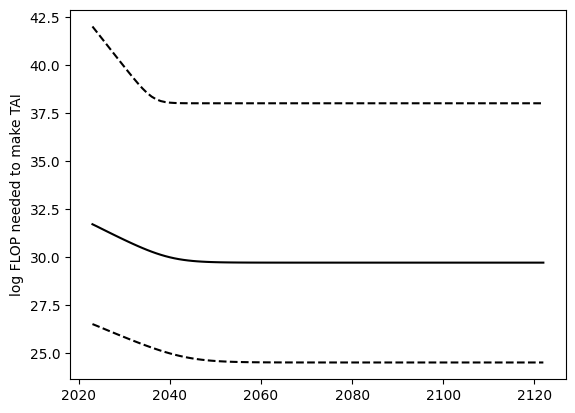

Year: 2023 - log FLOP needed for TAI 31.7 (~50 nonillion) 90% CI 26.5 (~316 septillion) - 42.0 (~1 billion decillion)
Year: 2024 - log FLOP needed for TAI 31.6 (~38 nonillion) 90% CI 26.4 (~254 septillion) - 41.7 (~500 million decillion)
Year: 2025 - log FLOP needed for TAI 31.5 (~29 nonillion) 90% CI 26.3 (~202 septillion) - 41.4 (~250 million decillion)
Year: 2026 - log FLOP needed for TAI 31.3 (~22 nonillion) 90% CI 26.2 (~161 septillion) - 41.1 (~125 million decillion)
Year: 2027 - log FLOP needed for TAI 31.2 (~17 nonillion) 90% CI 26.1 (~129 septillion) - 40.8 (~63 million decillion)
Year: 2028 - log FLOP needed for TAI 31.1 (~13 nonillion) 90% CI 26.0 (~103 septillion) - 40.5 (~31 million decillion)
Year: 2029 - log FLOP needed for TAI 31.0 (~10 nonillion) 90% CI 25.9 (~82 septillion) - 40.2 (~16 million decillion)
Year: 2030 - log FLOP needed for TAI 30.9 (~8 nonillion) 90% CI 25.8 (~66 septillion) - 39.9 (~8 million decillion)
Year: 2031 - log FLOP needed for TAI 30.8 (~6 noni

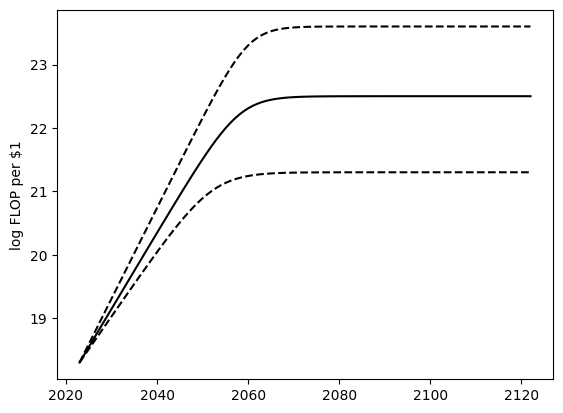

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~3 quintillion) - 18.4 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.6 (~4 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.7 (~5 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 18.9 (~7 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~7 quintillion) - 19.0 (~10 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.9 (~8 quintillion) - 19.2 (~14 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 19.0 (~11 quintillion) - 19.3 (~20 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.1 (~13 quintillion) - 19.4 (~28 quint

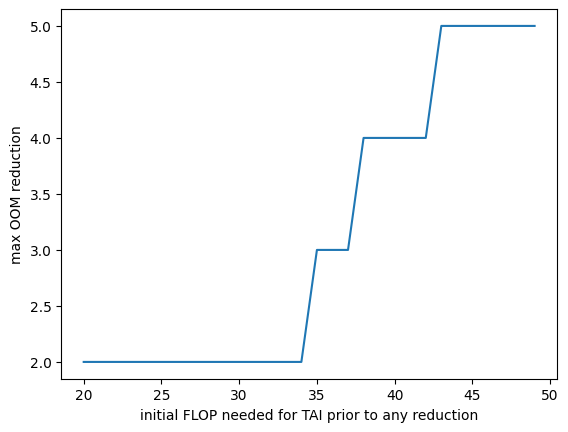

TAI log FLOP 20 -> 2.0 OOM reductions possible
TAI log FLOP 21 -> 2.0 OOM reductions possible
TAI log FLOP 22 -> 2.0 OOM reductions possible
TAI log FLOP 23 -> 2.0 OOM reductions possible
TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 

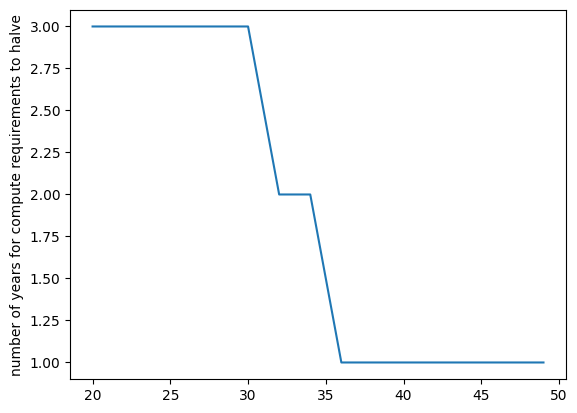

TAI log FLOP 20 -> algo doubling rate 3.0yrs
TAI log FLOP 21 -> algo doubling rate 3.0yrs
TAI log FLOP 22 -> algo doubling rate 3.0yrs
TAI log FLOP 23 -> algo doubling rate 3.0yrs
TAI log FLOP 24 -> algo doubling rate 3.0yrs
TAI log FLOP 25 -> algo doubling rate 3.0yrs
TAI log FLOP 26 -> algo doubling rate 3.0yrs
TAI log FLOP 27 -> algo doubling rate 3.0yrs
TAI log FLOP 28 -> algo doubling rate 3.0yrs
TAI log FLOP 29 -> algo doubling rate 3.0yrs
TAI log FLOP 30 -> algo doubling rate 3.0yrs
TAI log FLOP 31 -> algo doubling rate 2.5yrs
TAI log FLOP 32 -> algo doubling rate 2.0yrs
TAI log FLOP 33 -> algo doubling rate 2.0yrs
TAI log FLOP 34 -> algo doubling rate 2.0yrs
TAI log FLOP 35 -> algo doubling rate 1.5yrs
TAI log FLOP 36 -> algo doubling rate 1.0yrs
TAI log FLOP 37 -> algo doubling rate 1.0yrs
TAI log FLOP 38 -> algo doubling rate 1.0yrs
TAI log FLOP 39 -> algo doubling rate 1.0yrs
TAI log FLOP 40 -> algo doubling rate 1.0yrs
TAI log FLOP 41 -> algo doubling rate 1.0yrs
TAI log FL

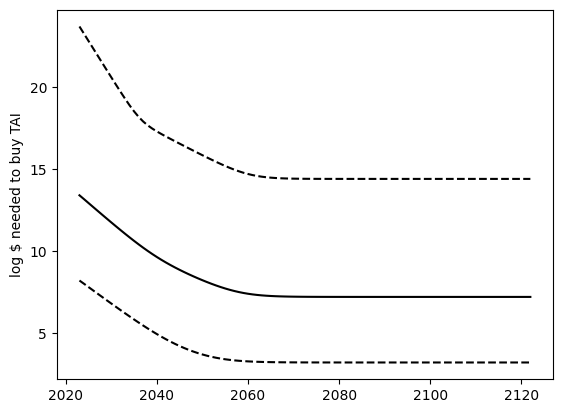

Year: 2023 - 13.4 log 2022$USD to buy TAI (~25 trillion) 90% CI 8.2 (~159 million) - 23.7 (~501 sextillion)
Year: 2024 - 13.2 log 2022$USD to buy TAI (~15 trillion) 90% CI 8.0 (~100 million) - 23.3 (~180 sextillion)
Year: 2025 - 12.9 log 2022$USD to buy TAI (~8 trillion) 90% CI 7.8 (~63 million) - 22.8 (~65 sextillion)
Year: 2026 - 12.7 log 2022$USD to buy TAI (~5 trillion) 90% CI 7.6 (~40 million) - 22.4 (~23 sextillion)
Year: 2027 - 12.4 log 2022$USD to buy TAI (~3 trillion) 90% CI 7.4 (~25 million) - 21.9 (~8 sextillion)
Year: 2028 - 12.2 log 2022$USD to buy TAI (~2 trillion) 90% CI 7.2 (~16 million) - 21.5 (~3 sextillion)
Year: 2029 - 12.0 log 2022$USD to buy TAI (~950 billion) 90% CI 7.0 (~10 million) - 21.0 (~1 sextillion)
Year: 2030 - 11.7 log 2022$USD to buy TAI (~554 billion) 90% CI 6.8 (~6 million) - 20.6 (~393 quintillion)
Year: 2031 - 11.5 log 2022$USD to buy TAI (~325 billion) 90% CI 6.6 (~4 million) - 20.2 (~143 quintillion)
Year: 2032 - 11.3 log 2022$USD to buy TAI (~192

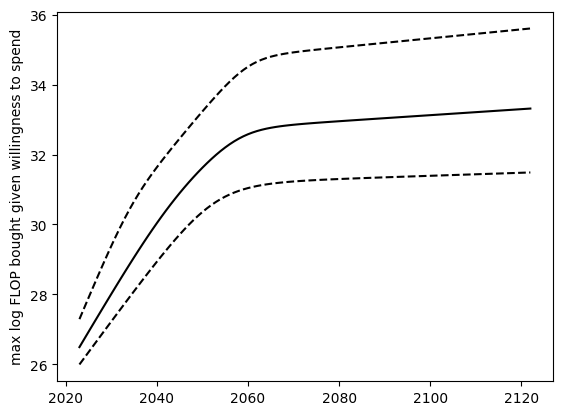

Year: 2023 - max log FLOP 26.5 (~311 septillion) 90% CI 26.0 (~99 septillion) - 27.3 (~2 octillion)
Year: 2024 - max log FLOP 26.7 (~515 septillion) 90% CI 26.2 (~149 septillion) - 27.6 (~4 octillion)
Year: 2025 - max log FLOP 26.9 (~852 septillion) 90% CI 26.3 (~223 septillion) - 27.9 (~8 octillion)
Year: 2026 - max log FLOP 27.1 (~1 octillion) 90% CI 26.5 (~335 septillion) - 28.2 (~16 octillion)
Year: 2027 - max log FLOP 27.4 (~2 octillion) 90% CI 26.7 (~502 septillion) - 28.5 (~32 octillion)
Year: 2028 - max log FLOP 27.6 (~4 octillion) 90% CI 26.9 (~752 septillion) - 28.8 (~64 octillion)
Year: 2029 - max log FLOP 27.8 (~6 octillion) 90% CI 27.1 (~1 octillion) - 29.1 (~126 octillion)
Year: 2030 - max log FLOP 28.0 (~10 octillion) 90% CI 27.2 (~2 octillion) - 29.4 (~244 octillion)
Year: 2031 - max log FLOP 28.2 (~17 octillion) 90% CI 27.4 (~3 octillion) - 29.7 (~463 octillion)
Year: 2032 - max log FLOP 28.4 (~27 octillion) 90% CI 27.6 (~4 octillion) - 29.9 (~858 octillion)
Year: 2033

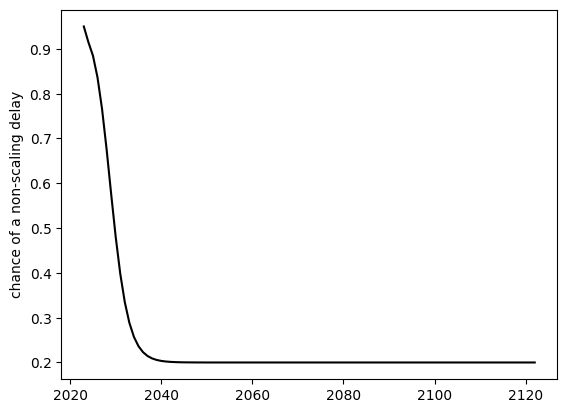

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 91%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 84%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 77%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 68%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 33%
Year: 2033

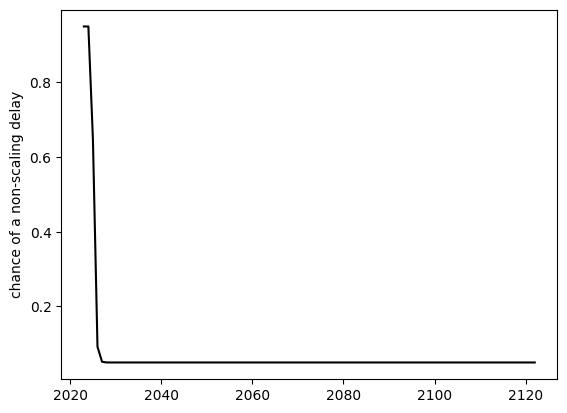

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 65%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chan

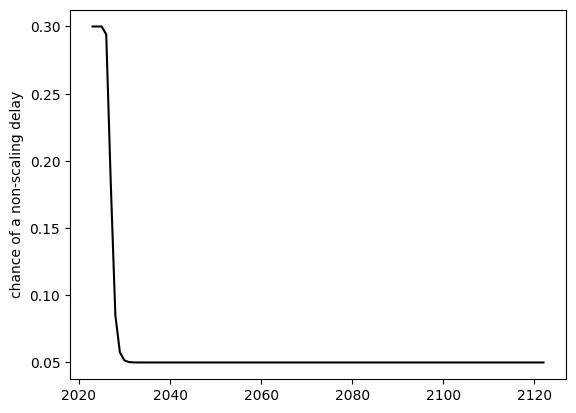

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - ch

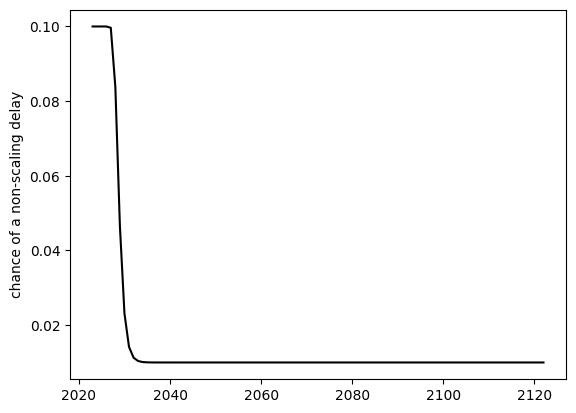

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 1%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 1%
Year: 2033 - ch

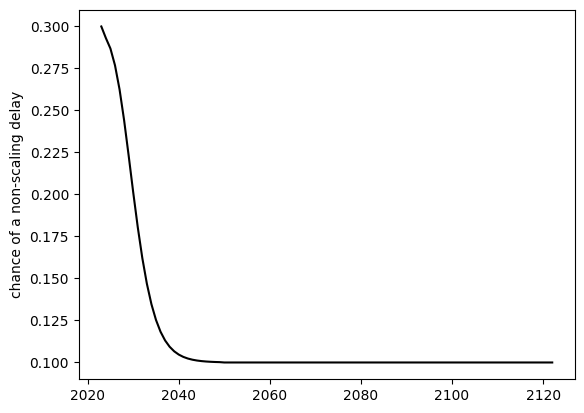

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2033

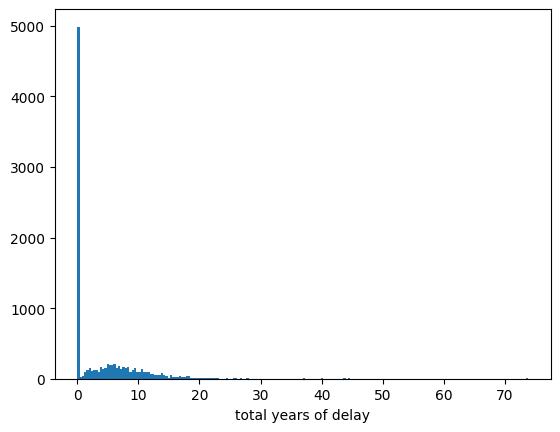

In [7]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 37.4 log FLOP (~25 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~34 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 3.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 37.4 log FLOP (25 thousand decillion) - log $ 19.1 to buy TAI (13 quintillion) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 37.1 log FLOP (13 thousand decillion) - log $ 18.7 to buy TAI (5 quintillion) vs. willingness to pay log $ 8.9 (765 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLO

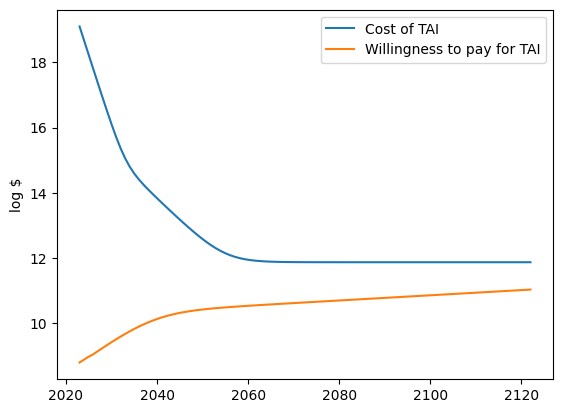

-
-
## SAMPLE RUN 5 ##
It takes 30.1 log FLOP (~1 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~583 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 2.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 30.1 log FLOP (1 nonillion) - log $ 11.8 to buy TAI (631 billion) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (840 septillion) available - TAI takes 30.0 log FLOP (967 octillion) - log $ 11.6 to buy TAI (363 billion) vs. willingness to pay log $ 8.5 (315 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max log FLOP (2 octillion) available -

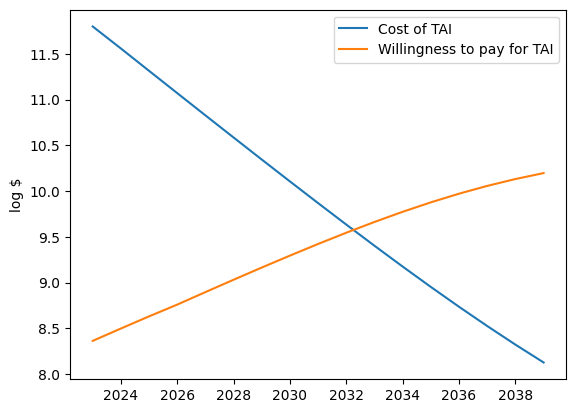

-
-
## SAMPLE RUN 6 ##
It takes 39.2 log FLOP (~2 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~875 million). This doubles every 3.9 years to a max of 0.030471% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 39.2 log FLOP (2 million decillion) - log $ 20.9 to buy TAI (795 quintillion) vs. willingness to pay log $ 8.9 (778 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 38.9 log FLOP (793 thousand decillion) - log $ 20.5 to buy TAI (286 quintillion) vs. willingness to pay log $ 9.0 (912 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.6 max log FLO

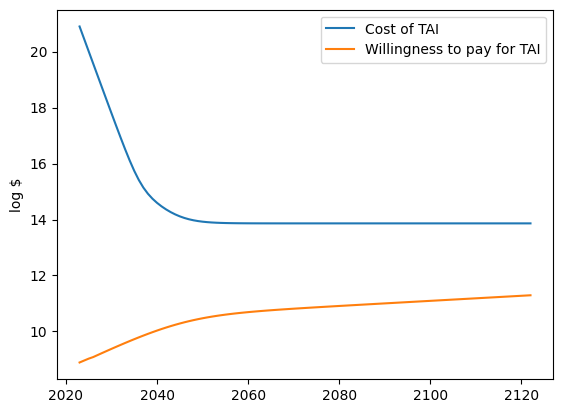

-
-
## SAMPLE RUN 7 ##
It takes 27.6 log FLOP (~4 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~187 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~62 million). This doubles every 2.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.1 max log FLOP (123 septillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (225 septillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 7.9 (80 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log FLOP (411 septillion) available - TAI take

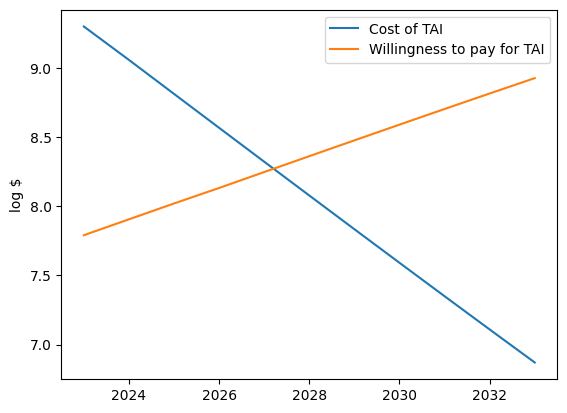

-
-
## SAMPLE RUN 8 ##
It takes 41.7 log FLOP (~501 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~76 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~390 million). This doubles every 1.9 years to a max of 0.082648% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.9 max log FLOP (762 septillion) available - TAI takes 41.7 log FLOP (501 million decillion) - log $ 23.4 to buy TAI (251 sextillion) vs. willingness to pay log $ 8.6 (382 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 41.4 log FLOP (251 million decillion) - log $ 23.0 to buy TAI (97 sextillion) vs. willingness to pay log $ 8.7 (541 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.4 max log

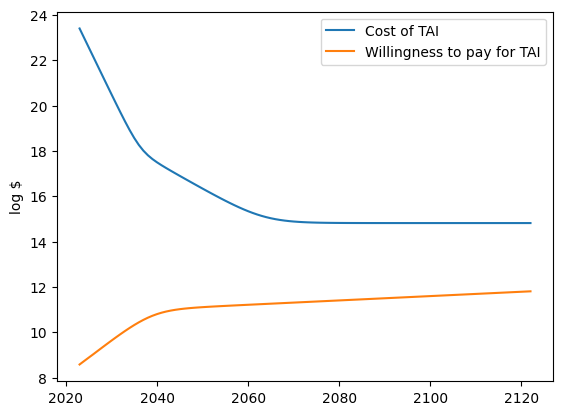

-
-
## SAMPLE RUN 9 ##
It takes 26.6 log FLOP (~398 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 2.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 26.6 log FLOP (398 septillion) - log $ 8.3 to buy TAI (200 million) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (341 septillion) available - TAI takes 26.5 log FLOP (320 septillion) - log $ 8.1 to buy TAI (125 million) vs. willingness to pay log $ 8.1 (133 million) - 18.4 log FLOP per $ (3 quintillion)
-- algorithms p_nonscaling_issue p=0.915 -> Nonscaling d

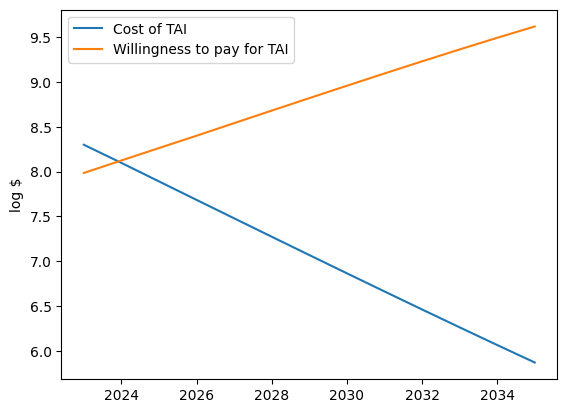

-
-
## SAMPLE RUN 10 ##
It takes 25.1 log FLOP (~13 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~185 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~194 million). This doubles every 3.0 years to a max of 0.028583% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.6 max log FLOP (375 septillion) available - TAI takes 25.1 log FLOP (13 septillion) - log $ 6.8 to buy TAI (6 million) vs. willingness to pay log $ 8.3 (188 million) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +5 years
-- data p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +1 years
-- robotics p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- real_world_feed

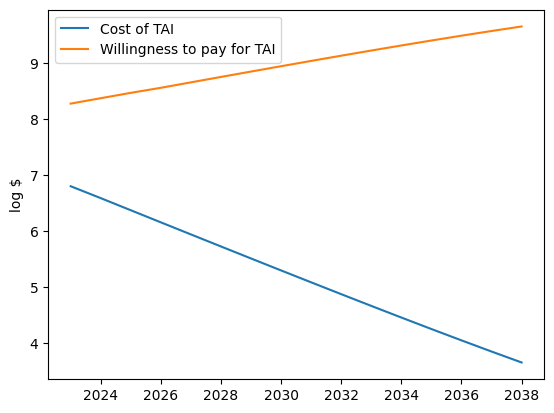

-
-
## SAMPLE RUN 11 ##
It takes 25.7 log FLOP (~50 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~38 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 3.3 years to a max of 0.041323% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.0 max log FLOP (99 septillion) available - TAI takes 25.7 log FLOP (50 septillion) - log $ 7.4 to buy TAI (25 million) vs. willingness to pay log $ 7.7 (50 million) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +4 years
-- data p_nonscaling_issue p=0.95 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- real_world_feedback p_nonscaling_issue p

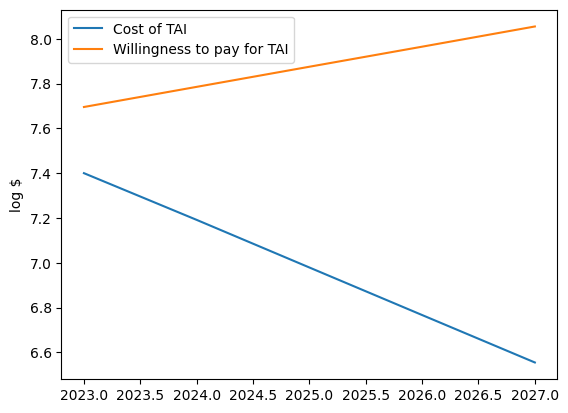

-
-
## SAMPLE RUN 12 ##
It takes 31.6 log FLOP (~40 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~569 million). This doubles every 2.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 31.6 log FLOP (40 nonillion) - log $ 13.3 to buy TAI (20 trillion) vs. willingness to pay log $ 8.7 (517 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 31.5 log FLOP (31 nonillion) - log $ 13.1 to buy TAI (12 trillion) vs. willingness to pay log $ 8.8 (673 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 octillion) available - TAI

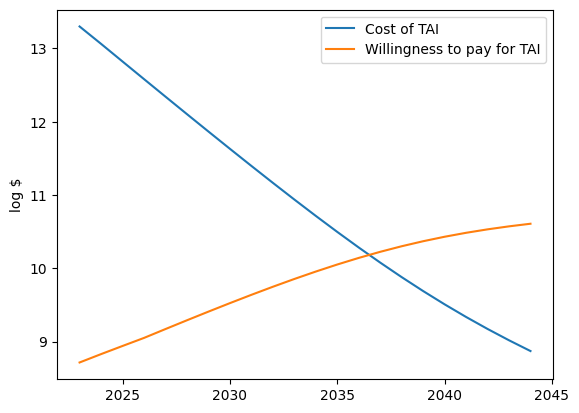

-
-
## SAMPLE RUN 13 ##
It takes 33.7 log FLOP (~5 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~90 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 4.7 years to a max of 0.062916% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.2 max log FLOP (157 septillion) available - TAI takes 33.7 log FLOP (5 decillion) - log $ 15.4 to buy TAI (3 quadrillion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (235 septillion) available - TAI takes 33.6 log FLOP (4 decillion) - log $ 15.1 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.0 (91 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLOP (352 septillion) avail

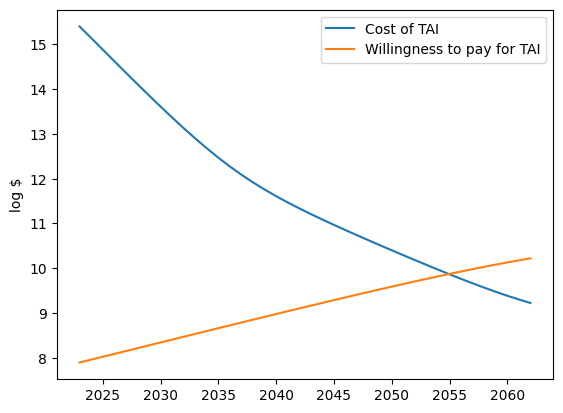

-
-
## SAMPLE RUN 14 ##
It takes 27.1 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~776 million). This doubles every 1.6 years to a max of 0.142404% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.8 to buy TAI (631 million) vs. willingness to pay log $ 8.9 (758 million) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +11 years
-- data p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +2 years
-- robotics p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- real_world_feedback p

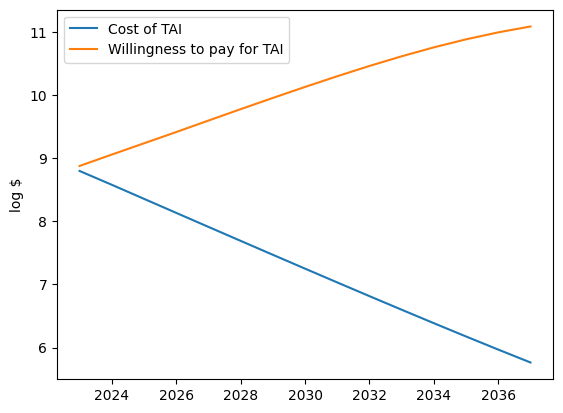

-
-
## SAMPLE RUN 15 ##
It takes 43.5 log FLOP (~32 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 2.2 years to a max of 0.099706% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.1 max log FLOP (125 septillion) available - TAI takes 43.5 log FLOP (32 billion decillion) - log $ 25.2 to buy TAI (16 septillion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (222 septillion) available - TAI takes 43.2 log FLOP (16 billion decillion) - log $ 24.8 to buy TAI (6 septillion) vs. willingness to pay log $ 7.9 (85 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log FLOP

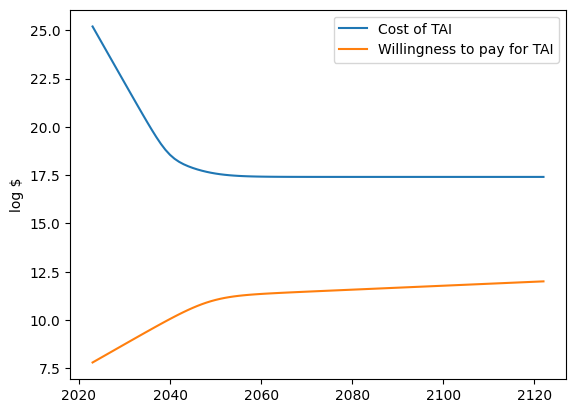

-
-
## SAMPLE RUN 16 ##
It takes 32.1 log FLOP (~126 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~79 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 3.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.037x per year.
---
Year: 2023 - 26.6 max log FLOP (372 septillion) available - TAI takes 32.1 log FLOP (126 nonillion) - log $ 13.8 to buy TAI (63 trillion) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (584 septillion) available - TAI takes 32.0 log FLOP (90 nonillion) - log $ 13.5 to buy TAI (35 trillion) vs. willingness to pay log $ 8.3 (224 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (916 septillion) avai

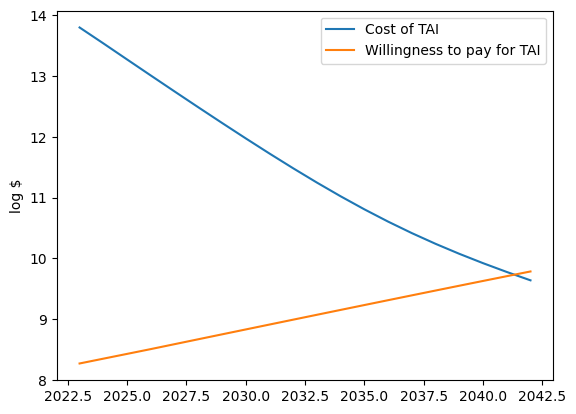

-
-
## SAMPLE RUN 17 ##
It takes 26.6 log FLOP (~398 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~18 sextillion) per 2022$USD.
We are initially willing to pay 7.3 log 2022$USD (~20 million). This doubles every 3.4 years to a max of 0.087491% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 25.6 max log FLOP (40 septillion) available - TAI takes 26.6 log FLOP (398 septillion) - log $ 8.3 to buy TAI (200 million) vs. willingness to pay log $ 7.3 (20 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 25.8 max log FLOP (66 septillion) available - TAI takes 26.5 log FLOP (320 septillion) - log $ 8.1 to buy TAI (118 million) vs. willingness to pay log $ 7.4 (24 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.0 max log FLOP (111 septillion) availa

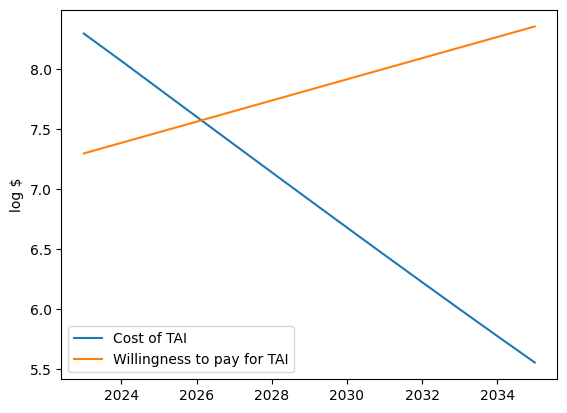

-
-
## SAMPLE RUN 18 ##
It takes 31.6 log FLOP (~40 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~31 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~247 million). This doubles every 2.6 years to a max of 0.07221% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.7 max log FLOP (486 septillion) available - TAI takes 31.6 log FLOP (40 nonillion) - log $ 13.3 to buy TAI (20 trillion) vs. willingness to pay log $ 8.4 (244 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (802 septillion) available - TAI takes 31.5 log FLOP (31 nonillion) - log $ 13.1 to buy TAI (12 trillion) vs. willingness to pay log $ 8.5 (317 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max log FLOP (1 octillion) availab

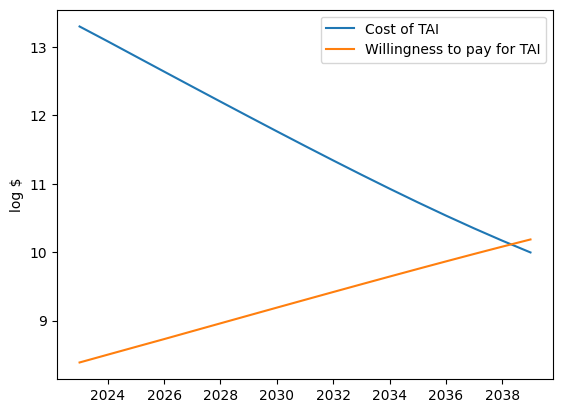

-
-
## SAMPLE RUN 19 ##
It takes 26.4 log FLOP (~251 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 3.8 years to a max of 0.025% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 26.4 log FLOP (251 septillion) - log $ 8.1 to buy TAI (126 million) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (291 septillion) available - TAI takes 26.3 log FLOP (202 septillion) - log $ 7.9 to buy TAI (80 million) vs. willingness to pay log $ 8.1 (115 million) - 18.4 log FLOP per $ (3 quintillion)
-- algorithms p_nonscaling_issue p=0.915 -> Nonscaling 

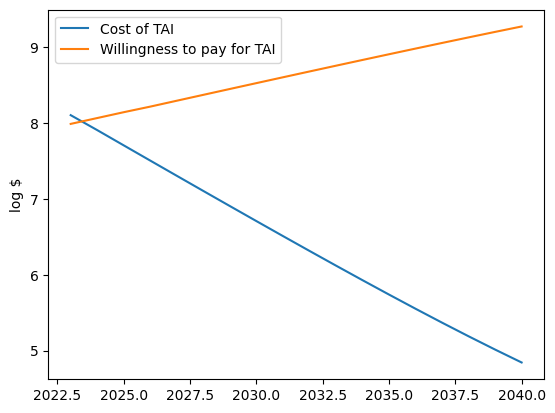

-
-
## SAMPLE RUN 20 ##
It takes 39.1 log FLOP (~1 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 3.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 39.1 log FLOP (1 million decillion) - log $ 20.8 to buy TAI (631 quintillion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (334 septillion) available - TAI takes 38.8 log FLOP (630 thousand decillion) - log $ 20.4 to buy TAI (228 quintillion) vs. willingness to pay log $ 8.1 (121 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log F

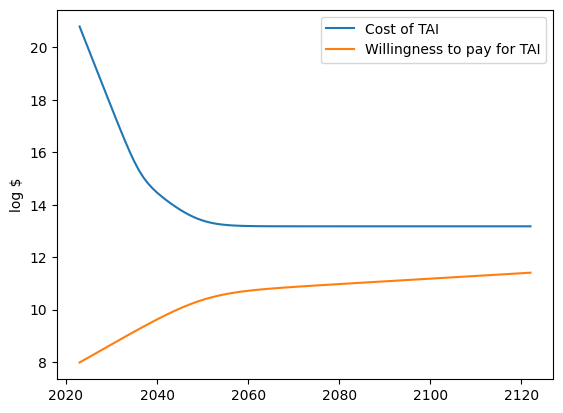

-
-
## SAMPLE RUN 21 ##
It takes 28.8 log FLOP (~63 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~52 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 3.3 years to a max of 0.095738% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.3 max log FLOP (198 septillion) available - TAI takes 28.8 log FLOP (63 octillion) - log $ 10.5 to buy TAI (32 billion) vs. willingness to pay log $ 8.0 (99 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (311 septillion) available - TAI takes 28.7 log FLOP (51 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 8.1 (122 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (489 septillion) availa

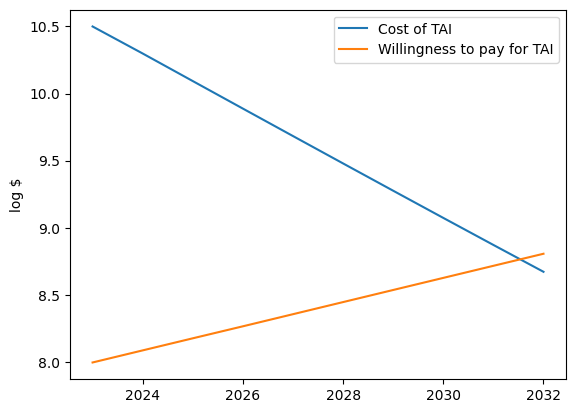

-
-
## SAMPLE RUN 22 ##
It takes 25.5 log FLOP (~32 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 2.6 years to a max of 0.03127% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.3 max log FLOP (194 septillion) available - TAI takes 25.5 log FLOP (32 septillion) - log $ 7.2 to buy TAI (16 million) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +6 years
-- data p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +4 years
-- robotics p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- real_world_feedbac

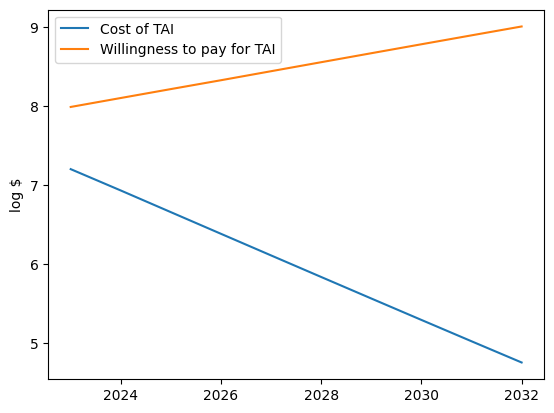

-
-
## SAMPLE RUN 23 ##
It takes 32.0 log FLOP (~100 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~31 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 1.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 32.0 log FLOP (100 nonillion) - log $ 13.7 to buy TAI (50 trillion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (391 septillion) available - TAI takes 31.9 log FLOP (72 nonillion) - log $ 13.4 to buy TAI (27 trillion) vs. willingness to pay log $ 8.2 (147 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP (791 septillion) availa

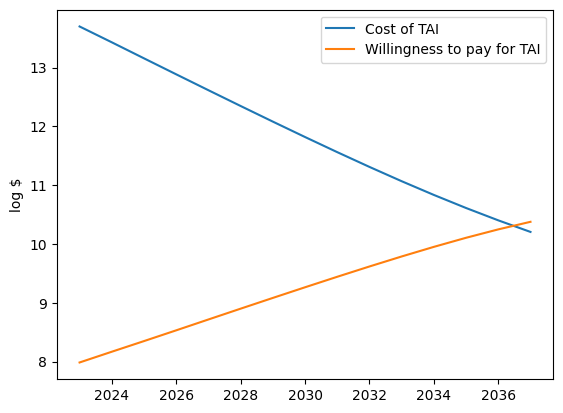

-
-
## SAMPLE RUN 24 ##
It takes 28.0 log FLOP (~10 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~21 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 2.4 years to a max of 0.337823% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.4 max log FLOP (250 septillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 8.1 (125 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (437 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 8.2 (168 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP (763 septillion) available 

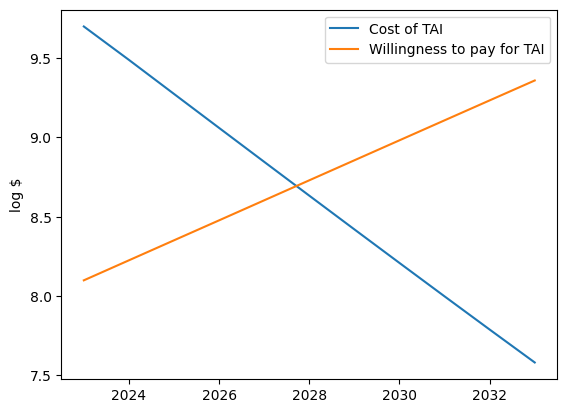

-
-
## SAMPLE RUN 25 ##
It takes 27.5 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~375 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 3.7 years to a max of 0.029207% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.1 max log FLOP (124 septillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (198 septillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.0 to buy TAI (955 million) vs. willingness to pay log $ 7.9 (75 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLOP (318 septillion) available - TA

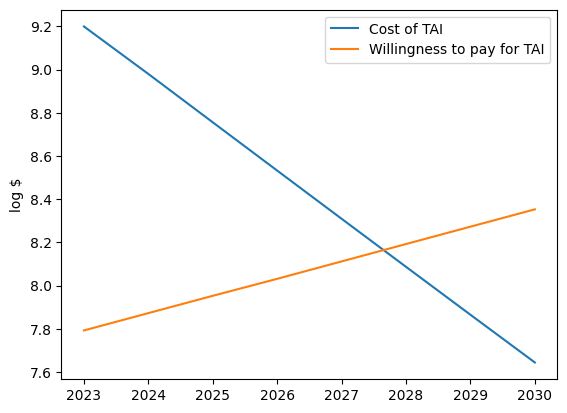

-
-
## SAMPLE RUN 26 ##
It takes 36.1 log FLOP (~1 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~194 million). This doubles every 3.3 years to a max of 0.03201% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.6 max log FLOP (378 septillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.8 to buy TAI (631 quadrillion) vs. willingness to pay log $ 8.3 (189 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (596 septillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.4 to buy TAI (246 quadrillion) vs. willingness to pay log $ 8.4 (233 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FL

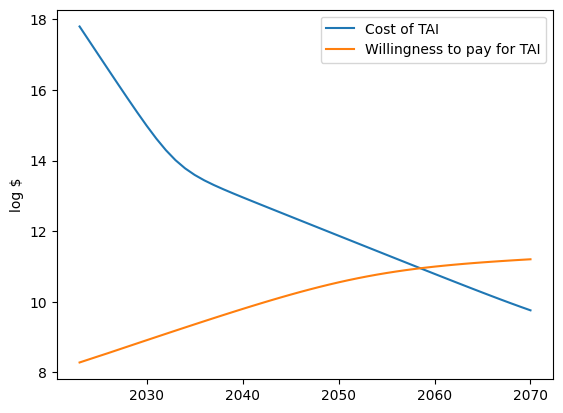

-
-
## SAMPLE RUN 27 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 9.8 log 2022$USD (~7 billion). This doubles every 1.9 years to a max of 0.08621% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 28.0 max log FLOP (10 octillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 9.7 (5 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 28.2 max log FLOP (18 octillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.1 to buy TAI (12 billion) vs. willingness to pay log $ 9.8 (6 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 28.5 max log FLOP (31 octillion) available - TAI tak

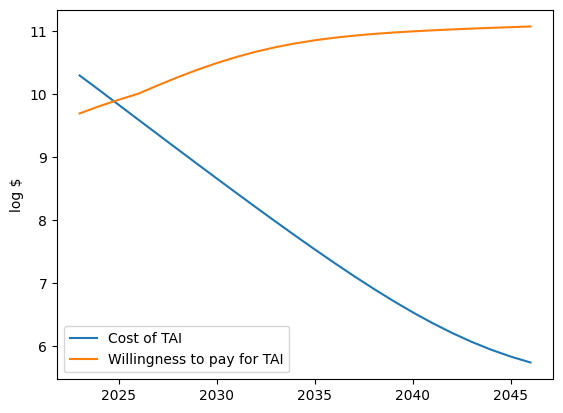

-
-
## SAMPLE RUN 28 ##
It takes 33.1 log FLOP (~1 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 3.7 years to a max of 0.025475% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 33.1 log FLOP (1 decillion) - log $ 14.8 to buy TAI (631 trillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (366 septillion) available - TAI takes 33.0 log FLOP (903 nonillion) - log $ 14.6 to buy TAI (358 trillion) vs. willingness to pay log $ 8.2 (145 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (557 septillion) av

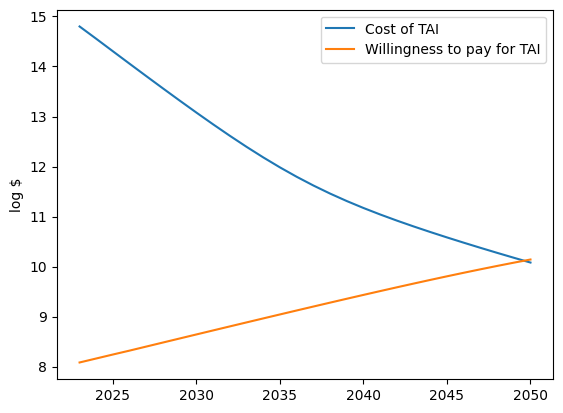

-
-
## SAMPLE RUN 29 ##
It takes 30.4 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~31 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~618 million). This doubles every 3.1 years to a max of 0.131854% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 30.4 log FLOP (3 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.8 (606 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 11.9 to buy TAI (796 billion) vs. willingness to pay log $ 8.9 (756 million) - 18.4 log FLOP per $ (2 quintillion)
Year: 2025 - 27.4 max log FLOP (3 octillion) available - TAI 

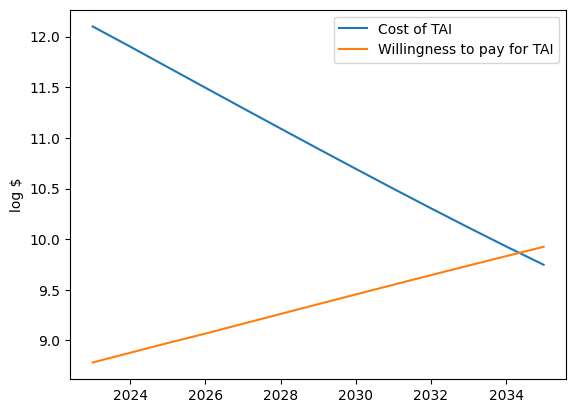

-
-
## SAMPLE RUN 30 ##
It takes 33.3 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 3.6 years to a max of 0.026814% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 25.9 max log FLOP (78 septillion) available - TAI takes 33.3 log FLOP (2 decillion) - log $ 15.0 to buy TAI (1 quadrillion) vs. willingness to pay log $ 7.6 (39 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.1 max log FLOP (121 septillion) available - TAI takes 33.2 log FLOP (1 decillion) - log $ 14.8 to buy TAI (564 trillion) vs. willingness to pay log $ 7.7 (48 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.3 max log FLOP (186 septillion) availabl

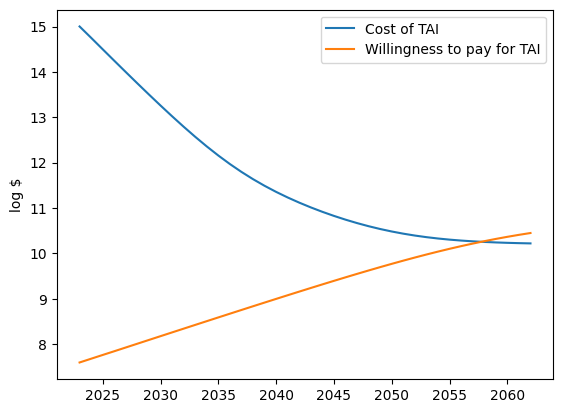

-
-
## SAMPLE RUN 31 ##
It takes 39.3 log FLOP (~2 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 1.7 years to a max of 0.060285% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 25.9 max log FLOP (79 septillion) available - TAI takes 39.3 log FLOP (2 million decillion) - log $ 21.0 to buy TAI (1 sextillion) vs. willingness to pay log $ 7.6 (40 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.2 max log FLOP (160 septillion) available - TAI takes 39.0 log FLOP (998 thousand decillion) - log $ 20.6 to buy TAI (367 quintillion) vs. willingness to pay log $ 7.8 (59 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLO

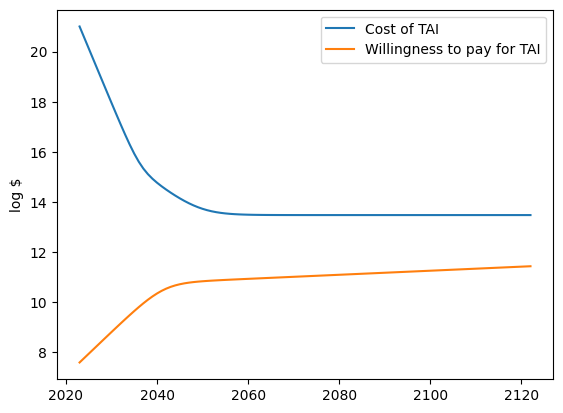

-
-
## SAMPLE RUN 32 ##
It takes 27.1 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~243 million). This doubles every 2.3 years to a max of 0.031767% of GDP. GDP grows at a rate of 1.036x per year.
---
Year: 2023 - 26.7 max log FLOP (469 septillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.8 to buy TAI (631 million) vs. willingness to pay log $ 8.4 (235 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (856 septillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.6 to buy TAI (371 million) vs. willingness to pay log $ 8.5 (314 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max log FLOP (2 octillion) available - TA

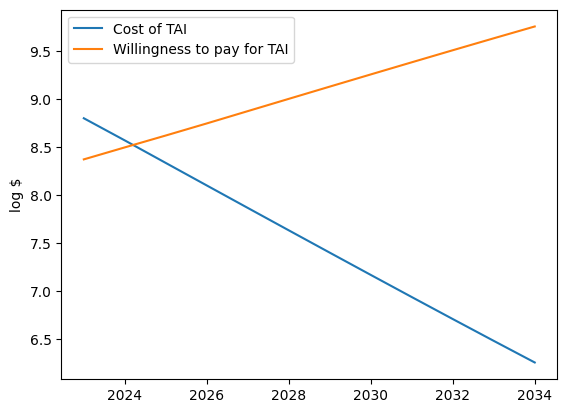

-
-
## SAMPLE RUN 33 ##
It takes 27.5 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 3.2 years to a max of 0.219204% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.5 max log FLOP (314 septillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 8.2 (157 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (528 septillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.0 to buy TAI (941 million) vs. willingness to pay log $ 8.3 (195 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP (887 septillion) available - TA

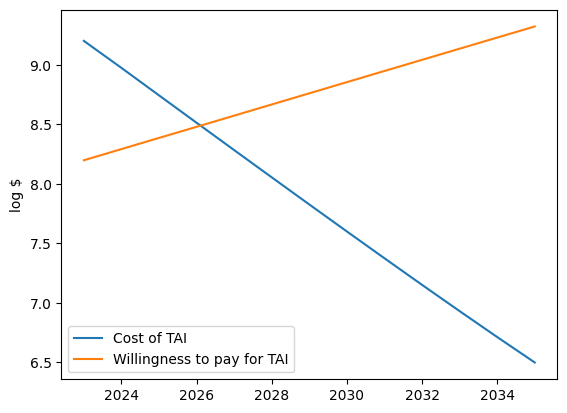

-
-
## SAMPLE RUN 34 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~62 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~377 million). This doubles every 3.2 years to a max of 0.03082% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.9 max log FLOP (714 septillion) available - TAI takes 26.2 log FLOP (158 septillion) - log $ 7.9 to buy TAI (79 million) vs. willingness to pay log $ 8.6 (358 million) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +4 years
-- data p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +4 years
-- robotics p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- real_world_fee

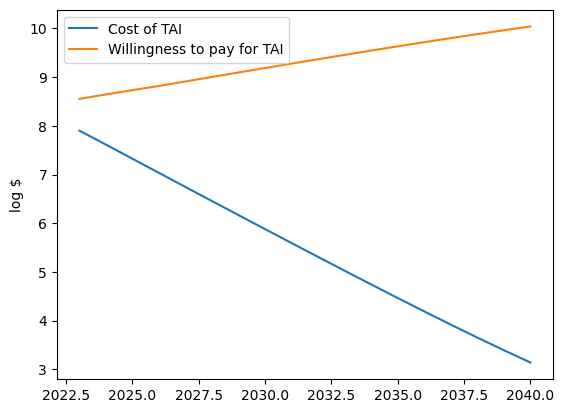

-
-
## SAMPLE RUN 35 ##
It takes 30.1 log FLOP (~1 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 2.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 30.1 log FLOP (1 nonillion) - log $ 11.8 to buy TAI (631 billion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (495 septillion) available - TAI takes 30.0 log FLOP (967 octillion) - log $ 11.6 to buy TAI (378 billion) vs. willingness to pay log $ 8.3 (193 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP (815 septillion) availabl

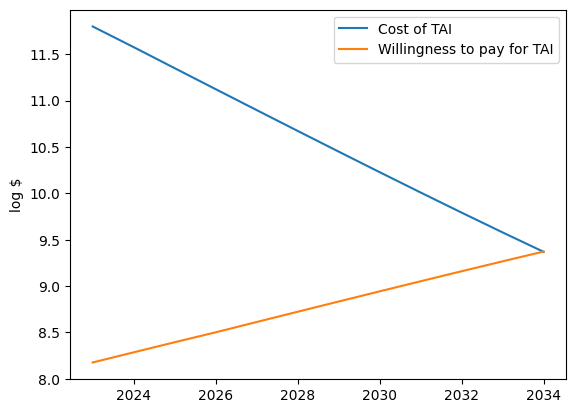

-
-
## SAMPLE RUN 36 ##
It takes 40.3 log FLOP (~20 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~233 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 2.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 40.3 log FLOP (20 million decillion) - log $ 22.0 to buy TAI (10 sextillion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (487 septillion) available - TAI takes 40.0 log FLOP (10 million decillion) - log $ 21.6 to buy TAI (4 sextillion) vs. willingness to pay log $ 8.3 (189 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FL

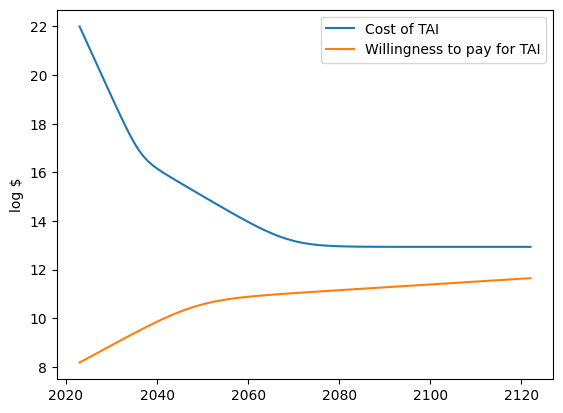

-
-
## SAMPLE RUN 37 ##
It takes 29.3 log FLOP (~200 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 1.6 years to a max of 0.647532% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.2 max log FLOP (158 septillion) available - TAI takes 29.3 log FLOP (200 octillion) - log $ 11.0 to buy TAI (100 billion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (308 septillion) available - TAI takes 29.2 log FLOP (160 octillion) - log $ 10.8 to buy TAI (63 billion) vs. willingness to pay log $ 8.1 (121 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (600 septillion) avai

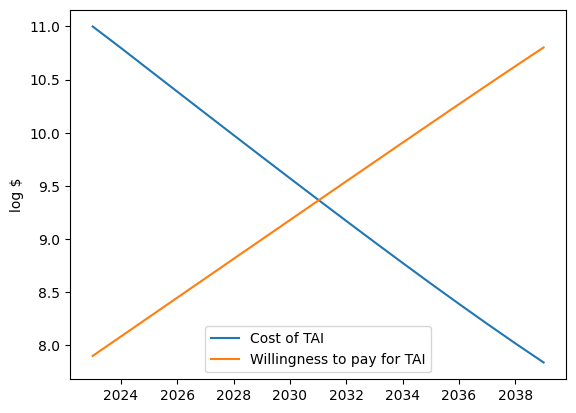

-
-
## SAMPLE RUN 38 ##
It takes 29.1 log FLOP (~126 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~18 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~78 million). This doubles every 2.7 years to a max of 0.029042% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.2 max log FLOP (155 septillion) available - TAI takes 29.1 log FLOP (126 octillion) - log $ 10.8 to buy TAI (63 billion) vs. willingness to pay log $ 7.9 (78 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (267 septillion) available - TAI takes 29.0 log FLOP (101 octillion) - log $ 10.6 to buy TAI (38 billion) vs. willingness to pay log $ 8.0 (100 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (459 septillion) avai

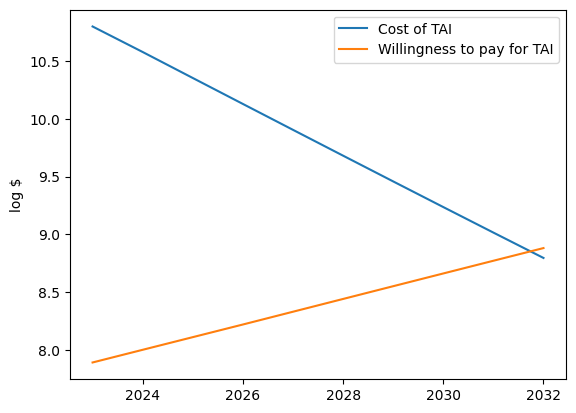

-
-
## SAMPLE RUN 39 ##
It takes 30.6 log FLOP (~4 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 2.1 years to a max of 0.06082% of GDP. GDP grows at a rate of 1.04x per year.
---
Year: 2023 - 26.1 max log FLOP (125 septillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (228 septillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 7.9 (87 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log FLOP (418 septillion) available - TA

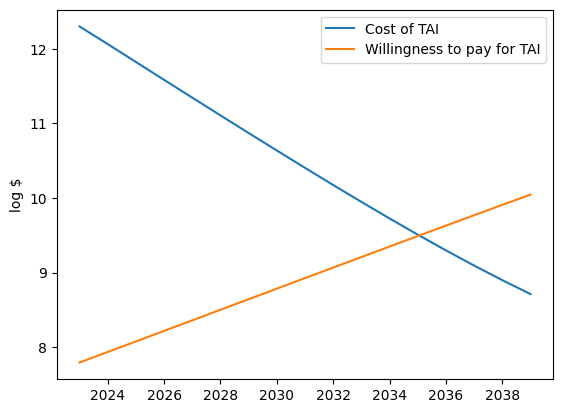

-
-
## SAMPLE RUN 40 ##
It takes 30.9 log FLOP (~8 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~320 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 3.7 years to a max of 0.035342% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.3 max log FLOP (195 septillion) available - TAI takes 30.9 log FLOP (8 nonillion) - log $ 12.6 to buy TAI (4 trillion) vs. willingness to pay log $ 8.0 (98 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (296 septillion) available - TAI takes 30.8 log FLOP (6 nonillion) - log $ 12.4 to buy TAI (2 trillion) vs. willingness to pay log $ 8.1 (117 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (449 septillion) available

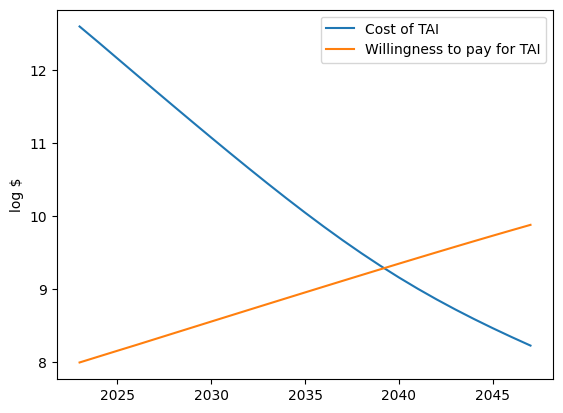

-
-
## SAMPLE RUN 41 ##
It takes 38.9 log FLOP (~794 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 2.6 years to a max of 0.073156% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 25.9 max log FLOP (79 septillion) available - TAI takes 38.9 log FLOP (794 thousand decillion) - log $ 20.6 to buy TAI (398 quintillion) vs. willingness to pay log $ 7.6 (40 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.1 max log FLOP (138 septillion) available - TAI takes 38.6 log FLOP (397 thousand decillion) - log $ 20.2 to buy TAI (149 quintillion) vs. willingness to pay log $ 7.7 (52 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 ma

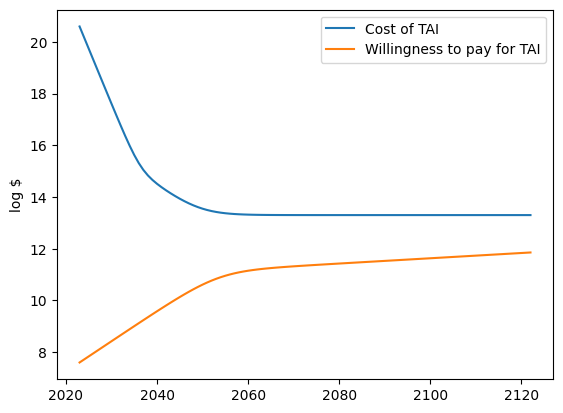

-
-
## SAMPLE RUN 42 ##
It takes 34.3 log FLOP (~20 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~17 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 3.8 years to a max of 0.546763% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.1 max log FLOP (126 septillion) available - TAI takes 34.3 log FLOP (20 decillion) - log $ 16.0 to buy TAI (10 quadrillion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (199 septillion) available - TAI takes 34.1 log FLOP (13 decillion) - log $ 15.7 to buy TAI (5 quadrillion) vs. willingness to pay log $ 7.9 (76 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLOP (314 septillion) a

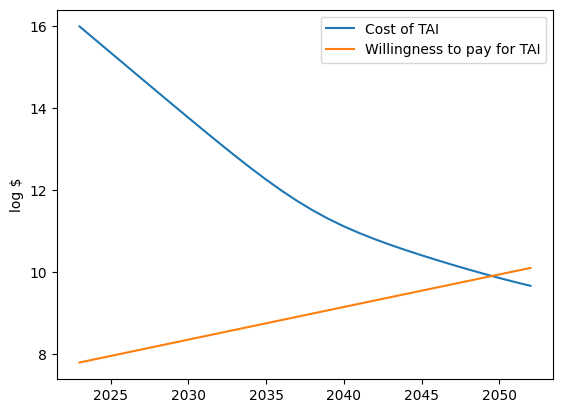

-
-
## SAMPLE RUN 43 ##
It takes 28.3 log FLOP (~20 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~373 million). This doubles every 3.0 years to a max of 0.025361% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.8 max log FLOP (699 septillion) available - TAI takes 28.3 log FLOP (20 octillion) - log $ 10.0 to buy TAI (10 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.8 to buy TAI (6 billion) vs. willingness to pay log $ 8.6 (435 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.3 max log FLOP (2 octillion) available - TA

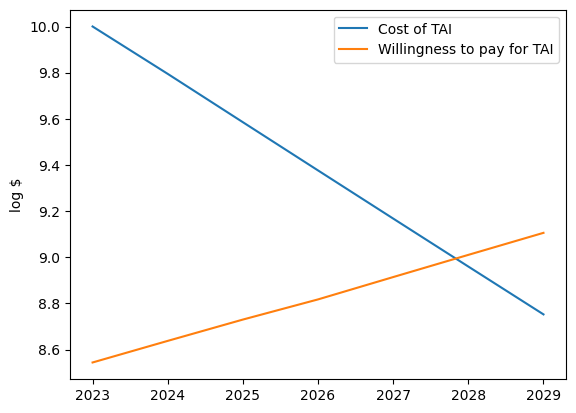

-
-
## SAMPLE RUN 44 ##
It takes 43.0 log FLOP (~10 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 1.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 43.0 log FLOP (10 billion decillion) - log $ 24.7 to buy TAI (5 septillion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (555 septillion) available - TAI takes 42.7 log FLOP (5 billion decillion) - log $ 24.3 to buy TAI (2 septillion) vs. willingness to pay log $ 8.3 (214 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (

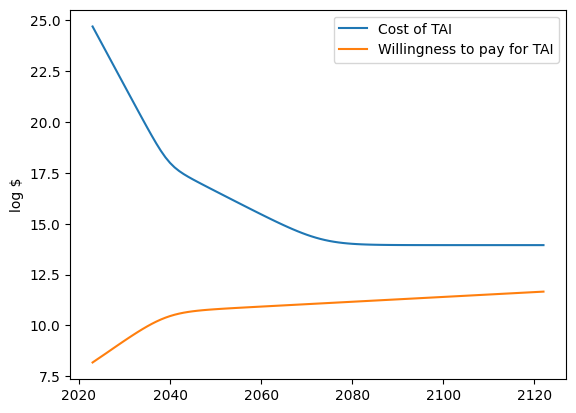

-
-
## SAMPLE RUN 45 ##
It takes 29.1 log FLOP (~126 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~105 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~711 million). This doubles every 3.8 years to a max of 0.029637% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.1 log FLOP (126 octillion) - log $ 10.8 to buy TAI (63 billion) vs. willingness to pay log $ 8.8 (644 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 29.0 log FLOP (101 octillion) - log $ 10.6 to buy TAI (37 billion) vs. willingness to pay log $ 8.9 (761 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 octillion) available 

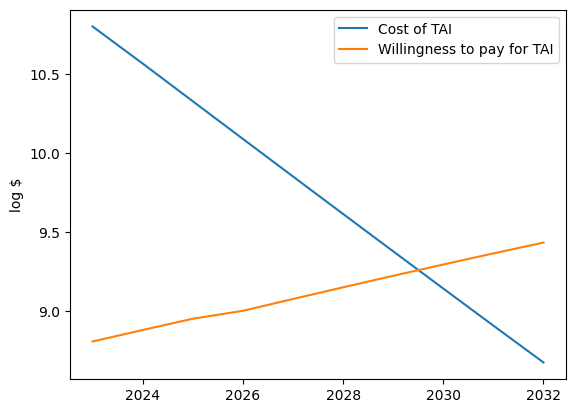

-
-
## SAMPLE RUN 46 ##
It takes 29.1 log FLOP (~126 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13 sextillion) per 2022$USD.
We are initially willing to pay 7.5 log 2022$USD (~32 million). This doubles every 2.5 years to a max of 0.058904% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 25.8 max log FLOP (63 septillion) available - TAI takes 29.1 log FLOP (126 octillion) - log $ 10.8 to buy TAI (63 billion) vs. willingness to pay log $ 7.5 (31 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.0 max log FLOP (108 septillion) available - TAI takes 29.0 log FLOP (101 octillion) - log $ 10.6 to buy TAI (39 billion) vs. willingness to pay log $ 7.6 (42 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.3 max log FLOP (187 septillion) availa

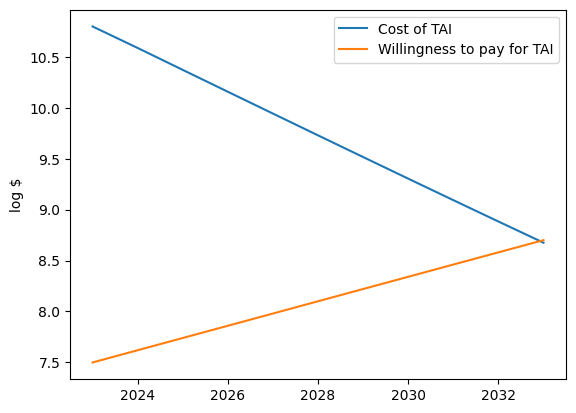

-
-
## SAMPLE RUN 47 ##
It takes 28.7 log FLOP (~50 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~745 million). This doubles every 1.6 years to a max of 0.05219% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.7 log FLOP (50 octillion) - log $ 10.4 to buy TAI (25 billion) vs. willingness to pay log $ 8.8 (701 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.2 to buy TAI (14 billion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.8 max log FLOP (6 octillion) available - TAI t

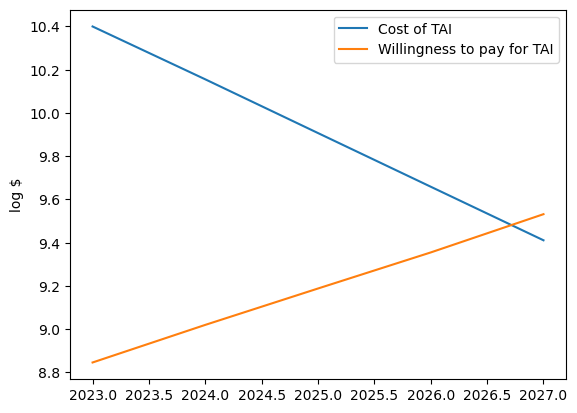

-
-
## SAMPLE RUN 48 ##
It takes 32.9 log FLOP (~794 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~35 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 2.8 years to a max of 0.025% of GDP. GDP grows at a rate of 1.009x per year.
---
Year: 2023 - 26.0 max log FLOP (98 septillion) available - TAI takes 32.9 log FLOP (794 nonillion) - log $ 14.6 to buy TAI (398 trillion) vs. willingness to pay log $ 7.7 (49 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (179 septillion) available - TAI takes 32.8 log FLOP (570 nonillion) - log $ 14.3 to buy TAI (201 trillion) vs. willingness to pay log $ 7.8 (63 million) - 18.5 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLOP (325 septillion) avail

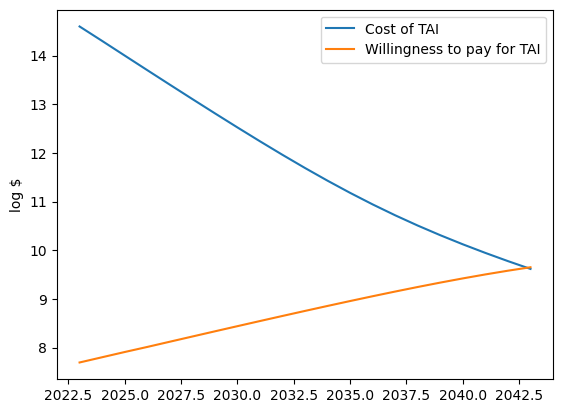

-
-
## SAMPLE RUN 49 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~191 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~308 million). This doubles every 3.0 years to a max of 0.054338% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.8 max log FLOP (601 septillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.6 to buy TAI (398 million) vs. willingness to pay log $ 8.5 (301 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 26.8 log FLOP (638 septillion) - log $ 8.4 to buy TAI (238 million) vs. willingness to pay log $ 8.6 (378 million) - 18.4 log FLOP per $ (3 quintillion)
-- algorithms p_nonscaling_issue p=0.915 -> Nonscal

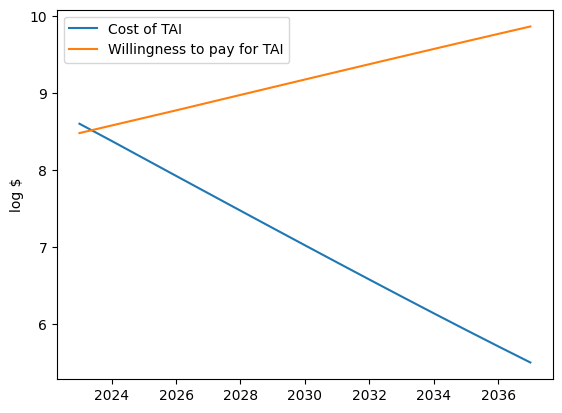

-
-
## SAMPLE RUN 50 ##
It takes 43.4 log FLOP (~25 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~248 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 3.5 years to a max of 0.049206% of GDP. GDP grows at a rate of 1.038x per year.
---
Year: 2023 - 26.2 max log FLOP (156 septillion) available - TAI takes 43.4 log FLOP (25 billion decillion) - log $ 25.1 to buy TAI (13 septillion) vs. willingness to pay log $ 7.9 (78 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (263 septillion) available - TAI takes 43.1 log FLOP (13 billion decillion) - log $ 24.7 to buy TAI (5 septillion) vs. willingness to pay log $ 8.0 (95 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log FL

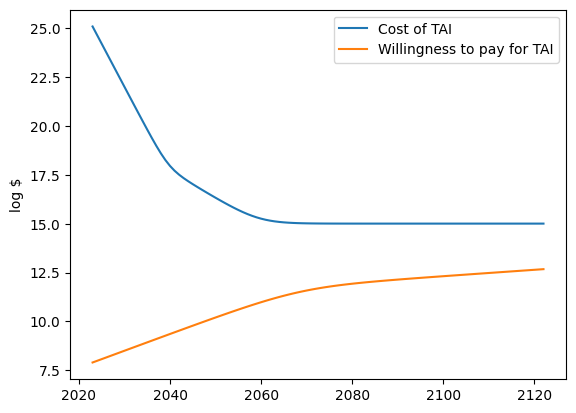

-
-
## SAMPLE RUN 51 ##
It takes 40.3 log FLOP (~20 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~810 quintillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 1.0 years until 2025, and then doubles every 1 years to a max of 0.164524% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.2 max log FLOP (157 septillion) available - TAI takes 40.3 log FLOP (20 million decillion) - log $ 22.0 to buy TAI (10 sextillion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (421 septillion) available - TAI takes 40.0 log FLOP (10 million decillion) - log $ 21.6 to buy TAI (4 sextillion) vs. willingness to pay log $ 8.2 (153 million) - 18.4 log FLOP per $

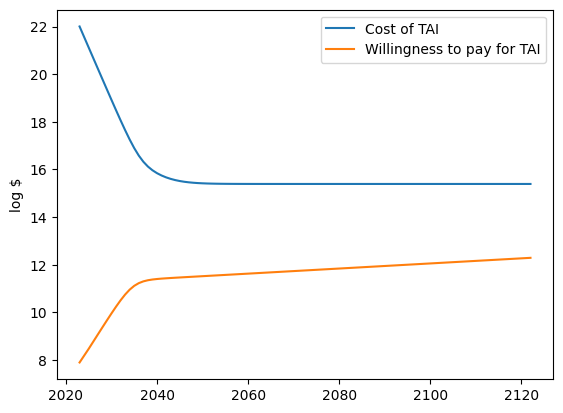

-
-
## SAMPLE RUN 52 ##
It takes 33.7 log FLOP (~5 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~22 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 3.6 years to a max of 0.053697% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.4 max log FLOP (246 septillion) available - TAI takes 33.7 log FLOP (5 decillion) - log $ 15.4 to buy TAI (3 quadrillion) vs. willingness to pay log $ 8.1 (123 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (386 septillion) available - TAI takes 33.6 log FLOP (4 decillion) - log $ 15.1 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.2 (150 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (605 septillion) av

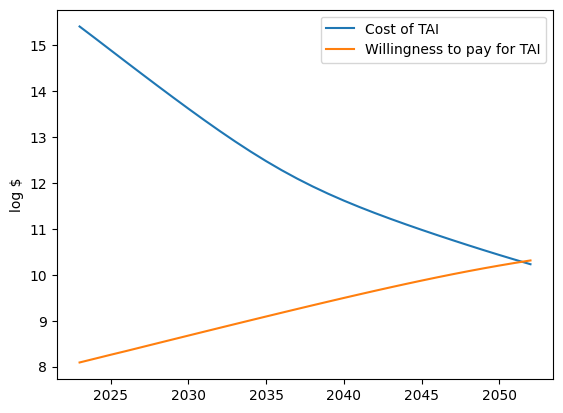

-
-
## SAMPLE RUN 53 ##
It takes 27.3 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~385 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 3.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 25.9 max log FLOP (78 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 7.6 (39 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.1 max log FLOP (128 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.8 to buy TAI (611 million) vs. willingness to pay log $ 7.7 (49 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.3 max log FLOP (208 septillion) available - TAI ta

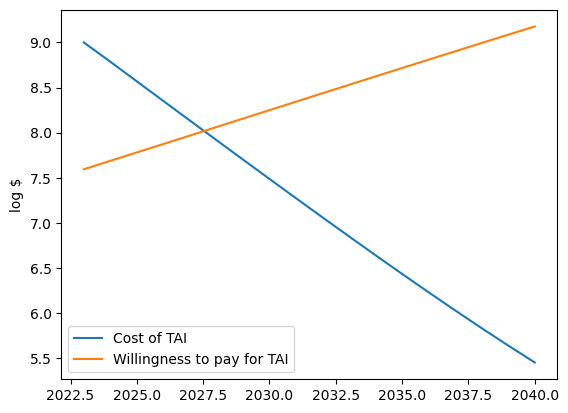

In [8]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(verbose=True)